In [2]:
# Colab setup
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

!git clone https://github.com/skylerroh/tldr-reddit-summarization.git
!cd tldr-reddit-summarization/ && git pull origin master && cd ..
!pip install transformers
!pip install tf-models-official
!pip install rouge-score

Fri Jul 31 17:52:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%load_ext autoreload
%autoreload 2
import json
import random
import sys
# sys.path.append('/Users/skylerroh/mids/tldr-reddit-summarization')
sys.path.append('tldr-reddit-summarization') # colab
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from preprocess import utils
from preprocess import preprocessing

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

import nltk
from nltk.tokenize import sent_tokenize
from transformers import DistilBertTokenizer, TFDistilBertModel
from lr_schedule import optimizer_w_warmup
from official import nlp
import official.nlp.optimization
import rouge_score
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
print(f'tf_version: {tf.__version__}')
print(f'nltk_version: {nltk.__version__}')
nltk.download('punkt')

tf_version: 2.3.0
nltk_version: 3.2.5
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
PAD_TOKEN_ID = tokenizer.convert_tokens_to_ids('[PAD]')
CLS_TOKEN_ID = tokenizer.convert_tokens_to_ids('[CLS]')
SEP_TOKEN_ID = tokenizer.convert_tokens_to_ids('[SEP]')
MAX_SENT_LENGTH = 40
MAX_DOC_LENGTH = 40

# Create BERT input for extractive summarization

In [8]:
def TFExampleToSentences(example, max_sentences=5, max_unigrams=256):
    doc_sent_list = [s.split() for s in sent_tokenize(example['inputs'].numpy().decode('utf-8'))]
    abstract_sent_list = [s.split() for s in sent_tokenize(example['targets'].numpy().decode('utf-8'))]
    extractive_sentence_ids = preprocessing.greedy_selection(doc_sent_list, 
                                               abstract_sent_list, 
                                               summary_size_sentences=max_sentences, 
                                               summary_size_unigrams=max_unigrams)
#     print(f'len of original post: {sum([len(s) for s in doc_sent_list])}')
#     print(f'len of extracted post: {sum([len(doc_sent_list[i]) for i in extractive_sentence_ids])}')
#     print(f'len of original summary: {sum([len(s) for s in abstract_sent_list])}')
#     print(sorted([i / len(doc_sent_list) for i in extractive_sentence_ids]))
#     print(sum([len(i) for i in doc_sent_list]) / len(doc_sent_list))
#     print(len(doc_sent_list))
    locations = sorted([i / len(doc_sent_list) for i in extractive_sentence_ids])
    return doc_sent_list, extractive_sentence_ids, locations

In [9]:
# input for HiBert architecture

np.random.seed(20200720)

def encodeSentence(sentence, max_sent_length):
    src_tokens = tokenizer.tokenize(sentence)
    src_tokens = ['[CLS]'] + src_tokens
    src_tokens = src_tokens[:max_sent_length]
    src_tokens += ['[PAD]'] * (max_sent_length - len(src_tokens))
    src_mask = [1] * len(src_tokens) + [0] * (max_sent_length - len(src_tokens))
    return src_tokens, src_mask

def sentencesToHiBert(doc_sent_list, extractive_sentence_ids, max_sent_length=40, max_num_sentences=32, min_sent_length=5):
    num_sent = len(doc_sent_list)
    labels = []
        
    word_tokens_list, word_token_ids_list, word_mask_list = [], [], []
    
    num_sent = 0
    for i, sent in enumerate(doc_sent_list):
        if len(sent) < min_sent_length:
            continue
        word_tokens, word_mask = encodeSentence(' '.join(sent), max_sent_length)
        word_token_ids = tokenizer.convert_tokens_to_ids(word_tokens)
        word_tokens_list.append(word_tokens)
        word_token_ids_list.append(word_token_ids)
        word_mask_list.append(word_mask)
        num_sent += 1
        labels.append(int(i in extractive_sentence_ids))
           
        
    
    all_PAD = ['CLS'] + ['[PAD]'] * (max_sent_length - 1)
    all_PAD_ids = [CLS_TOKEN_ID] + [PAD_TOKEN_ID] * (max_sent_length - 1)
    
    add_sentences = max_num_sentences - num_sent
    sent_mask = [1] * max_num_sentences
    if add_sentences > 0:
        word_tokens_list += [all_PAD for _ in range(add_sentences)]
        word_token_ids_list += [all_PAD_ids for _ in range(add_sentences)]
        word_mask_list += [[0] * max_sent_length for _ in range(add_sentences)]
        sent_mask = [1] * num_sent + [0] * (add_sentences)
        labels += [2] * add_sentences
    elif add_sentences < 0:
        start = max_num_sentences // 2
        end = num_sent - (max_num_sentences - (max_num_sentences // 2))
        
        word_tokens_list = word_tokens_list[:start] + word_tokens_list[end:]
        word_token_ids_list = word_token_ids_list[:start] + word_token_ids_list[end:]
        word_mask_list = word_mask_list[:start] + word_mask_list[end:]
        labels = labels[:start] + labels[end:]
    
    return word_tokens_list, word_token_ids_list, word_mask_list, sent_mask, labels




In [22]:
data = {}

for key, f in [('eval', 'eval_top50_5k.tfrecord')]:#, ('train', 'train_top50_100k.tfrecord')]: 
    print(f"{key} data")
    word_token_ids_list = []
    word_lvl_masks_list = []
    sent_lvl_masks_list = []
    labels_list = []

    dataset = utils.build(f, False)
    doc_num_sentences = []
    doc_num_tokens = []

    for i, example in enumerate(dataset):
        if i % 10**4==0:
            print(i)
        doc_sent_list, extractive_sentence_ids, locations = TFExampleToSentences(example)
        doc_num_sentences.append(len(doc_sent_list))

        word_tokens, word_token_ids, word_mask, sent_mask, labels = sentencesToHiBert(doc_sent_list, 
                                                                                      extractive_sentence_ids, 
                                                                                      max_sent_length=MAX_SENT_LENGTH, 
                                                                                      max_num_sentences=MAX_DOC_LENGTH,
                                                                                      min_sent_length=4)
        
        doc_num_tokens.append(sum([sum(m) - 1 if sum(m) > 0 else sum(m) for m in word_mask]))

        word_token_ids_list.append(word_token_ids)
        word_lvl_masks_list.append(word_mask)
        sent_lvl_masks_list.append(sent_mask)
        labels_list.append(labels)
    print(i+1, "examples in", key)
    indices = np.arange(len(word_token_ids_list))
    np.random.shuffle(indices)
    print(indices[:5])

    print("Mean number of sentences:", sum(doc_num_sentences) / len(doc_num_sentences))
    print("Mean number of tokens:", sum([nt / len(doc_num_tokens) for nt in doc_num_tokens]))
              
    data[key] = {"input_ids":np.array(word_token_ids_list)[indices], 
                 "input_word_masks": np.array(word_lvl_masks_list)[indices], 
                 "input_sentence_masks": np.array(sent_lvl_masks_list)[indices],
                 "labels": np.array(labels_list)[indices]}

eval data
0
4362 examples in eval
[ 784 4231 1196 2235  273]
Mean number of sentences: 19.73016964695094
Mean number of tokens: 644.3046767537837


In [23]:
def get_data(data, key, batch_size, limit=None):
    if not limit:
        limit = len(data[key]['input_ids'])
    if batch_size:
        limit = (limit//batch_size) * batch_size
    return [data[key][i][:limit] for i in ['input_ids', 'input_word_masks', 'input_sentence_masks']]
            
def get_labels(data, key, batch_size, limit=None):
    if not limit:
        limit = len(data[key]['input_ids'])
    if batch_size:
        limit = (limit//batch_size) * batch_size
    return data[key]['labels'][:limit]

## Utility Methods

In [11]:
def mask_and_reshape(y_true, y_pred):
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 2)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, 3]) # there are 3 possible labels
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return y_label_masked, y_flat_pred_masked


def set_pad_value(mask, y, y_pad_value=0, dtype=tf.float32):
    pad_replace = tf.where(mask, y, tf.constant(y_pad_value, dtype=tf.float32))
    return pad_replace


def custom_crossentropy_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """
    y_label_masked, y_flat_pred_masked = mask_and_reshape(y_true, y_pred)
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False))


def get_class_predictions(pred, class_id):
    B, S, P = pred.shape
    pos_pred_slice = tf.squeeze(tf.slice(pred, [0, 0, class_id], [B, S, 1]), axis=2)
    return pos_pred_slice


def custom_recall_top_k(y_true, y_pred, k):
    mask = (y_true < 2)
    
    B, S, P = y_pred.shape
    
    y_true = tf.reshape(y_true, [B, S])
    pos_pred_slice = get_class_predictions(y_pred, class_id=1)
    y_label_masked = set_pad_value(mask, y_true, 0, tf.int64)
    y_1_pred_masked = set_pad_value(mask, pos_pred_slice, -float('Inf'), tf.float32)

    top_values, top_indices = tf.nn.top_k(y_1_pred_masked, k=k)
    top_k_labels = tf.gather(y_label_masked, top_indices, batch_dims=1)
    recall_top_k = tf.math.reduce_sum(top_k_labels, axis=1) / (tf.math.reduce_sum(y_label_masked, axis=1) + tf.constant(1.0e-8))
    # mask where none labeled as 1
    recall_top_k_masked = tf.boolean_mask(recall_top_k, tf.math.is_finite(recall_top_k))
    return tf.reduce_mean(recall_top_k_masked)


def custom_recall_top_5(y_true, y_pred):
    return custom_recall_top_k(y_true, y_pred, 5)


def custom_recall_top_10(y_true, y_pred):
    return custom_recall_top_k(y_true, y_pred, 10)


def custom_recall_top_20(y_true, y_pred):
    return custom_recall_top_k(y_true, y_pred, 20)

In [12]:
y_true = tf.constant([[1, 0, 2]])

y_pred = tf.constant([[
    [0.6,0.4,0],
    [0.5,0.2,0.3],
    [1, 0, 0]
]], shape=[1, 3, 3])

custom_crossentropy_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.804719>

In [13]:
(-np.log(0.4) + -np.log(0.5)) / 2

0.8047189562170501

In [14]:
preds = tf.constant([[0.1, 0.9, 0.2],
                    [0.5, 0.5, 0.5],
                    [0.1, 0.6, 0.0],
                    [0.2, 0.1, 0.0]], tf.float32)
labels = tf.constant([[0, 1, 1],
                      [1, 0, 0],
                      [0, 1, 1],
                      [1, 1, 0]], tf.int32)
print(preds.shape)
print(labels.shape)

(4, 3)
(4, 3)


## Model Layers

In [15]:
class SentenceBertLayer(tf.keras.layers.Layer):
    def __init__(self, transformer, sent_embed_method='average'):
        super(SentenceBertLayer, self).__init__()
        self.transformer = transformer
        self.sent_embed_method = sent_embed_method
    
    def __call__(self, input):
        in_id, in_mask = input
        batch_size = in_id.shape[0]
        num_sentences = in_id.shape[1]
        transformer_embedding_size = 768
        
        init_encode = tf.zeros([BATCH_SIZE, num_sentences, transformer_embedding_size], dtype=tf.float32)
        _, _, _, encoded = tf.while_loop(
            self.loop_cond, self.encode_loop,
            [tf.constant(0, dtype=tf.int32), in_id, in_mask, init_encode])

        return encoded

    def encode_loop(self, i, in_id, in_mask, init_encode):
        B, S, E = init_encode.shape
        cur_in_id = tf.gather(in_id, i, axis=1)
        cur_in_mask = tf.gather(in_mask, i, axis=1)
        last_hidden_states = self.transformer((cur_in_id, cur_in_mask))[0]
        if self.sent_embed_method == 'cls':
          cur_output = tf.slice(last_hidden_states, [0, 0, 0], [B, 1, E], name='sent_embeddings')
          cur_output = tf.squeeze(cur_output, 1)
        elif self.sent_embed_method == 'average':
          hidden_states_masked = last_hidden_states * \
              tf.cast(cur_in_mask, tf.float32)[:, :, tf.newaxis]
          cur_output = tf.reduce_sum(hidden_states_masked, axis=1) \
              / (tf.reduce_sum(tf.cast(cur_in_mask, dtype=tf.float32), axis=1)[:, tf.newaxis] + tf.constant(1e-8))
        else:
          raise("sentence embedding method must be in ['cls', 'average']")
        init_encode = self.inplace_update_i(init_encode, cur_output, i)
        return i + 1, in_id, in_mask, init_encode

    def loop_cond(self, i, in_id, in_mask, init_encode):
        return i < in_id.shape[1]
    
    def inplace_update_i(self, tensor_BxSxE, updates_B, i):
        """Inplace update a tensor. B: batch_size, S: num_sentences, E:embedding_dim."""
        batch_size = tensor_BxSxE.shape[0]
        indices_Bx2 = tf.stack([
            tf.range(batch_size, dtype=tf.int64),
            tf.fill([batch_size], tf.cast(i, tf.int64))
        ], axis=-1)
        return tf.tensor_scatter_nd_update(tensor_BxSxE, indices_Bx2, updates_B)

In [16]:
class ScaledDotProductAttentionLayer():
    def calculate_output_weights(self, q, k, v, mask):
        qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  

        weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(weights, v)

        return output, weights

In [17]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_neurons, num_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        
        self.num_heads = num_heads
        self.num_neurons = num_neurons
        self.depth = num_neurons // self.num_heads
        self.attention_layer = ScaledDotProductAttentionLayer()
        
        self.q_layer = Dense(num_neurons)
        self.k_layer = Dense(num_neurons)
        self.v_layer = Dense(num_neurons)

        self.linear_layer = Dense(num_neurons)

    def split(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # Run through linear layers
        q = self.q_layer(q)
        k = self.k_layer(k)
        v = self.v_layer(v)

        # Split the heads
        q = self.split(q, batch_size)
        k = self.split(k, batch_size)
        v = self.split(v, batch_size)

        # Run through attention
        attention_output, weights = self.attention_layer.calculate_output_weights(q, k, v, mask)
        
        # Prepare for the rest of processing
        output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.num_neurons))
        
        # Run through final linear layer
        output = self.linear_layer(concat_attention)

        return output, weights

In [18]:
BATCH_SIZE = 8

def extractive_hibert_model(sent_max_input_length, doc_max_input_length, 
                            train_layers, ff_dim, ff_dropout, optimizer, 
                            sent_encode_method='average', k=20):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(doc_max_input_length, sent_max_input_length,), dtype='int32', name="input_ids")
    in_word_mask = tf.keras.layers.Input(shape=(doc_max_input_length, sent_max_input_length,), dtype='int32', name="input_word_masks")
    in_sent_mask = tf.keras.layers.Input(shape=(doc_max_input_length,), dtype='int32', name="input_sentence_masks")
    
    sent_bert_layer = TFDistilBertModel.from_pretrained('distilbert-base-cased').distilbert
    doc_bert_layer = TFDistilBertModel.from_pretrained('distilbert-base-cased').distilbert
    doc_position_embeddings = doc_bert_layer.embeddings.position_embeddings
    
    sent_bert = SentenceBertLayer(sent_bert_layer, sent_encode_method)
    sent_bert_sequence = sent_bert((in_id, in_word_mask))

    # stop gradients from flowing through distilbert for sentence representation
    sent_bert_sequence = tf.stop_gradient(sent_bert_sequence)

    # use position embeddings for the sentences
    position_ids = tf.range(doc_max_input_length, dtype=tf.int32)[tf.newaxis, :]
    doc_bert_position_embeddings = doc_position_embeddings(position_ids)

    dense = sent_bert_sequence + doc_bert_position_embeddings

    invert_mask = tf.cast(tf.logical_not(tf.cast(in_sent_mask, tf.bool)), tf.float32)
    invert_mask_broadcast = invert_mask[:, tf.newaxis, tf.newaxis, :] 
    dense = MultiHeadAttentionLayer(256, 4)(dense, dense, dense, mask=invert_mask_broadcast)[0]
    
    # feed sentence representations through dense layers
    for i, d in enumerate(ff_dim):
      dense = tf.keras.layers.Dense(d, activation=tf.nn.leaky_relu, name='dense_{}'.format(i))(dense)
      dense = tf.keras.layers.Dropout(rate=ff_dropout)(dense)

    pred = tf.keras.layers.Dense(3, activation='softmax', name='is_summary')(dense)
     
    print('pred: ', pred)

    losses = {"is_summary": custom_crossentropy_loss,}
    lossWeights = {"is_summary": 1.0}

    model = tf.keras.models.Model(inputs=[in_id, in_word_mask, in_sent_mask], outputs=pred)
    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_crossentropy_loss, custom_recall_top_5, custom_recall_top_10, custom_recall_top_20])

    return model

## Build and compare hyperparams

In [19]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

histories = []
for l in [0.0005]:
    for d in [[128]]: # [[128]*5]:
        for o in [0.1]:
            print("learning_rate: {}, hidden_dim: {}, dropout: {}".format(l, d, o))

            # lr = create_lr_schedule(init_lr=l, num_train_steps=10187*4, num_warmup_steps=10187)
            # optimizer = tf.keras.optimizers.Adam(lr=l, beta_1=0.9, beta_2=0.999, decay=0.1, amsgrad=False)

            optimizer = nlp.optimization.create_optimizer(l, num_train_steps=10187*4, num_warmup_steps=10187)
            

            model = extractive_hibert_model(MAX_SENT_LENGTH, MAX_DOC_LENGTH, train_layers=0, ff_dim=d, ff_dropout=o, optimizer=optimizer, sent_encode_method='average')
            break
            history = model.fit(
                get_data(data, 'train', BATCH_SIZE), 
                {"is_summary": get_labels(data, 'train', BATCH_SIZE)},
                validation_data=(get_data(data, 'eval', BATCH_SIZE), {"is_summary":get_labels(data, 'eval', BATCH_SIZE)}),
                epochs=6,
                batch_size=BATCH_SIZE
            )
            print("training done, saving model")
            model_save_name = "attention_model" #f'l-{l}_hd-{str(d)}_o-{o}.model' 
            path = f"/content/gdrive/My Drive/{model_save_name}" 
            model.save(path)
            model.save_weights(path+".h5")
            # Get the dictionary containing each metric and the loss for each epoch
            history_dict = history.history
            # Save it under the form of a json file
            json.dump(history_dict, open(f"{path}.json", 'w')) #f"/content/gdrive/My Drive/history-l-{l}_hd-{str(d)}_o-{o}.json"
            histories.append({'learning_rate': l, 'hidden_dim': d, 'dropout':o, 'history': history})
            pred = model(get_data(data, 'eval', BATCH_SIZE, 8))[0]
            print(pred[:10])


INFO:absl:using Adamw optimizer


learning_rate: 0.0005, hidden_dim: [128], dropout: 0.1


- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical

pred:  Tensor("is_summary/truediv:0", shape=(8, 40, 3), dtype=float32)


In [20]:
## reload recently train weights in case of kernel restart
# model.load_weights("/content/gdrive/My Drive/attention_model.h5")

In [24]:
## check that evaluation metrics are the same after loading weights
# model.evaluate(get_data(data, 'eval', BATCH_SIZE), get_labels(data, 'eval', BATCH_SIZE), batch_size=8)

545/545 [==============================] - 160s 293ms/step - loss: 0.4541 - custom_crossentropy_loss: 0.4541 - custom_recall_top_5: 0.5951 - custom_recall_top_10: 0.8164 - custom_recall_top_20: 0.9390


[0.4541380703449249,
 0.4541380703449249,
 0.5951111912727356,
 0.8163729906082153,
 0.9389616847038269]

In [28]:
for i in histories:
  for k in ('learning_rate', 'hidden_dim', 'dropout'):
    print(k, ':', i[k])
  history = i['history']
  for m in ['custom_crossentropy_loss', 'custom_recall_top_5', 'custom_recall_top_10', 'custom_recall_top_20']:
    plt.plot(history.history[m])
    plt.plot(history.history['val_' + m], style=':')
    plt.title(m.replace('custom_', ''))
    plt.ylabel(m.replace('custom_', ''))
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

### Compare Downstream FFN only to MHA + FFN

In [56]:
attention_history = json.load(open("/content/gdrive/My Drive/attention_model.json", 'r'))
ff_history = json.load(open("/content/gdrive/My Drive/history-l-0.0005_hd-[128, 128, 128, 128, 128]_o-0.1_e6.json", 'r'))

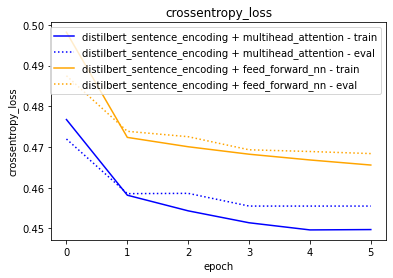

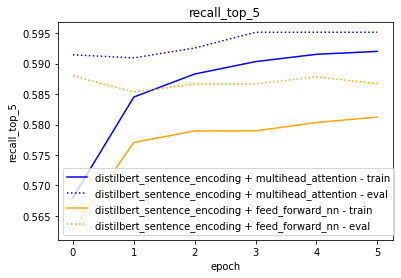

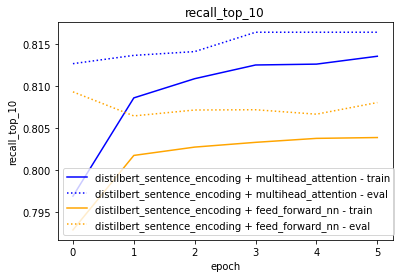

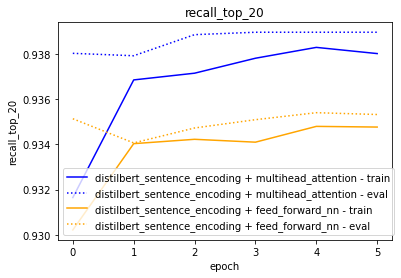

In [63]:
for m in ['custom_crossentropy_loss', 'custom_recall_top_5', 'custom_recall_top_10', 'custom_recall_top_20']:
    for i, (name, history) in enumerate((('multihead_attention', attention_history), 
                                         ('feed_forward_nn', ff_history))):
        color = ['blue', 'orange'][i]
        plt.plot(history[m], color=color, label=f"distilbert_sentence_encoding + {name} - train")
        plt.plot(history['val_' + m], linestyle=':', color=color, label=f"distilbert_sentence_encoding + {name} - eval")
        plt.title(m.replace('custom_', ''))
        plt.ylabel(m.replace('custom_', ''))
        plt.xlabel('epoch')
    plt.legend()
    plt.show()

## Write extractive text to new TFRecords
### Methods
*   parse batches of the original TFRecords
*   run predictions
*   get top k sentences to write as new inputs for PEGASUS


In [25]:
def construct_extractive_summary(pred, k, in_id, in_word_mask, in_sent_mask):
    y_pred_1s = tf.squeeze(tf.slice(pred, [0, 1], [len(in_id), 1]), axis=1)
    y_pred_pad_neg = set_pad_value(in_sent_mask==1, y_pred_1s, -float('Inf'), tf.float32)
    top_values, top_indices = tf.nn.top_k(y_pred_pad_neg, k=k)
    top_k_minus_pad_mask = tf.slice(in_sent_mask, [0], [k])
    top_k_non_pad = tf.sort(tf.ragged.boolean_mask(top_indices, top_k_minus_pad_mask==1)).numpy()
    # print(top_k_non_pad)
    # num_tokens = sum([sum(m) - 1 for m in in_word_mask[top_k_non_pad]])
    return in_id[top_k_non_pad]

def ids_to_example_text(sentences):
    final_sent = []
    for sent in sentences:
        final_sent.append(tokenizer.decode(sent, skip_special_tokens=True))
    return ' '.join(final_sent)

def get_inputs_from_batch(examples):
    word_token_ids_list = []
    word_lvl_masks_list = []
    sent_lvl_masks_list = []
    for example in examples:
        doc_sent_list, extractive_sentence_ids, locations = TFExampleToSentences(example)

        _, word_token_ids, word_mask, sent_mask, _ = sentencesToHiBert(doc_sent_list, 
                                                                                      extractive_sentence_ids, 
                                                                                      max_sent_length=MAX_SENT_LENGTH, 
                                                                                      max_num_sentences=MAX_DOC_LENGTH,
                                                                                      min_sent_length=4)
        word_token_ids_list.append(word_token_ids)
        word_lvl_masks_list.append(word_mask)
        sent_lvl_masks_list.append(sent_mask)
    inputs = (np.array(word_token_ids_list), np.array(word_lvl_masks_list), np.array(sent_lvl_masks_list))
    return inputs

def get_extracted_text_from_preds(preds, inputs, k):
    new_text = []
    new_num_tokens = []
    for i, pred in enumerate(preds):
        in_id = inputs[0][i]
        in_word_mask = inputs[1][i]
        in_sent_mask = inputs[2][i]

        id_sentences = construct_extractive_summary(pred, k, in_id, in_word_mask, in_sent_mask)
        txt = ids_to_example_text(id_sentences)
        new_text.append(txt)
        new_num_tokens.append(len(tokenizer.tokenize(txt)))
    return new_text, new_num_tokens


### Writer and visualize


*   iterate through batches of 1000 examples
*   visualize distribution of original token lengths to new extracted text based on top k sentences



eval data
0
1000
2000
3000
4000
wrote 4362 new tf records to /content/gdrive/My Drive/eval_top50_5k.tfrecord_extracted_transformer_top20.tfrecord
previous average number of input tokens 438.8745988078868
new average number of input tokens, k=10, 231.56166895919395
new average number of input tokens, k=20, 315.818890417241
sd length, original, 386.92692383004606
sd length, k=10, 81.66815339538365
sd length, k=20, 165.60042403614585
max length, original, 4487
max length, k=10, 390
max length, k=20, 767


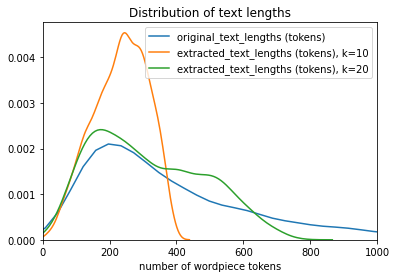

train data
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [ ]:
k = 20 # get up to top k sentences

for key, f in [('eval', 'eval_top50_5k.tfrecord'), ('train', 'train_top50_100k.tfrecord')]: 
    print(f"{key} data")
    filename = f'/content/gdrive/My Drive/{f}_extracted_transformer_top{k}.tfrecord'

    dataset = utils.build(f, False)
    batched = dataset.batch(1000)

    original_text_lengths = []
    new_text_lengths10 = []
    new_text_lengths20 = [] 
    with tf.io.TFRecordWriter(filename) as writer:

        for i, batch in enumerate(batched.as_numpy_iterator()):
            word_token_ids_list = []
            word_lvl_masks_list = []
            sent_lvl_masks_list = []
            labels_list = []
            print(i*1000)
            
            del batch['supervised']
            cur_batch_size = len(batch['inputs'])
            examples = [{k: tf.constant(v[i]) for k, v in batch.items()} for i in range(cur_batch_size)]

            if cur_batch_size % BATCH_SIZE != 0:
                examples.extend([{'inputs': tf.constant("[PAD]"), "targets": tf.constant("[PAD]")} for i in range(BATCH_SIZE-(cur_batch_size % BATCH_SIZE))])

            inputs = get_inputs_from_batch(examples)
            preds = model.predict(inputs, batch_size=BATCH_SIZE)
            
            new_text10, new_num_tokens10 = get_extracted_text_from_preds(preds, inputs, 10)
            new_text20, new_num_tokens20 = get_extracted_text_from_preds(preds, inputs, 20)
            original_num_tokens = [len(tokenizer.tokenize(e['inputs'].numpy().decode('utf-8'))) for e in examples]
            original_text_lengths.extend(original_num_tokens[:cur_batch_size])
            new_text_lengths10.extend(new_num_tokens10[:cur_batch_size])
            new_text_lengths20.extend(new_num_tokens20[:cur_batch_size])
            for n, example in enumerate(examples[:cur_batch_size]):
                example["inputs"] = tf.constant(new_text[n])
                record_bytes = utils.serialize_example(**example)
                writer.write(record_bytes)

        # show stats of new records
        print(f"wrote {i*1000+cur_batch_size} new tf records to {filename}")
        print(f"previous average number of input tokens {sum([t / len(original_text_lengths) for t in original_text_lengths])}")
        print(f"new average number of input tokens, k=10, {sum([t / len(new_text_lengths10) for t in new_text_lengths10])}")
        print(f"new average number of input tokens, k=20, {sum([t / len(new_text_lengths20) for t in new_text_lengths20])}")
        
        print(f"sd length, original, {np.std(np.array(original_text_lengths))}")
        print(f"sd length, k=10, {np.std(np.array(new_text_lengths10))}")
        print(f"sd length, k=20, {np.std(np.array(new_text_lengths20))}")
        
        print(f"max length, original, {max(original_text_lengths)}")
        print(f"max length, k=10, {max(new_text_lengths10)}")
        print(f"max length, k=20, {max(new_text_lengths20)}")
        sns.kdeplot(original_text_lengths, label="original_text_lengths (tokens)")
        sns.kdeplot(new_text_lengths10, label="extracted_text_lengths (tokens), k=10")
        sns.kdeplot(new_text_lengths20, label="extracted_text_lengths (tokens), k=20")
        plt.xlim(0, 1000)
        plt.title("Distribution of text lengths")
        plt.xlabel("number of wordpiece tokens")
        plt.legend()
        plt.show()

        # g = sns.jointplot(x=original_text_lengths, y=new_text_lengths, 
        #               xlim=(0, 1000), ylim=(0,1000), kind="kde")
        # g.fig.suptitle("Joint Distribution of Original and Extracted Lengths (k=10)")
        # g.set_axis_labels("original_text_lengths", "extracted_text_lengths")
        # plt.show()